In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

from  sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,fbeta_score,roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import random
from random import choices
from sklearn.metrics import fbeta_score, make_scorer

In [2]:

## F-Beta Score
def F_Beta_score(test_y, predict_y):
    FBScore = fbeta_score(test_y, predict_y,beta=2)
    return FBScore

## Total_cost
def Cost(test_y, predict_y):
    matrix = confusion_matrix(test_y, predict_y)
    FP = matrix[0][1]
    FN = matrix[1][0]
    cost = FP*10 + FN*500
    return cost

# Function to plot confusion matrix in heatmaps
def matrix_heatmaps(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points :",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1]
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1);
    sns.heatmap(C, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);
    # labels, title and ticks
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix');
   
    plt.subplot(1,3,2)
    sns.heatmap(B, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Precision Matrix');

    ax = plt.subplot(1,3,3)
    sns.heatmap(A, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Recall Matrix');  

# Custom Stacking Classifier

#### Obtaining Train and testing (CV) dataset

In [3]:
X = pd.read_csv('saves_2/X_train_oversampled.csv',index_col=0)
Y = pd.read_csv('saves_2/Y_train_oversampled.csv',index_col=0).values.flatten()

X_cv = pd.read_csv('saves_2//X_cv_eda.csv',index_col=0)
X_cv = X_cv.reset_index(drop=True)
Y_cv = pd.read_csv('saves_2//Y_cv_eda.csv',index_col=0).values.flatten()

#### Splitting the Train Dataset to D1 and D2 with a 50% split

In [20]:
def D1_D2_split(X,Y):
    X_D1,X_D2,Y_D1,Y_D2 = train_test_split(X,Y,test_size=0.5,stratify=Y)
    X_D1 = X_D1.reset_index(drop=True)
    X_D2 = X_D2.reset_index(drop=True)

    print('Shape of X_train:',X.shape)
    print('Shape of X_cv   :',X_cv.shape)
    print('Shape of X_D1   :',X_D1.shape)
    print('Shape of X_D2   :',X_D2.shape)
    
    return X_D1,X_D2,Y_D1,Y_D2

X_D1,X_D2,Y_D1,Y_D2 = D1_D2_split(X,Y)

Shape of X_train: (94400, 157)
Shape of X_cv   : (12000, 157)
Shape of X_D1   : (47200, 157)
Shape of X_D2   : (47200, 157)


In [155]:
X.to_csv('saves3//X.csv')
Y_df = pd.DataFrame(Y,columns=['Y'])
Y_df.to_csv('saves3//Y.csv')

X_D1.to_csv('saves3//X_D1.csv')
X_D2.to_csv('saves3//X_D2.csv')
Y_D1_df = pd.DataFrame(Y_D1,columns=['Y_D1'])
Y_D1_df.to_csv('saves3//Y_D1.csv')
Y_D2_df = pd.DataFrame(Y_D2,columns=['Y_D2'])
Y_D2_df.to_csv('saves3//Y_D2.csv')

#### Generating 'K' samples by sampling with replacement from X_D1 with size of each sample being half of X_D1 

In [5]:
def samples_from_D1(X,Y,k):
    
    X_samples_list = []
    Y_samples_list = []
    
    for i in range(k):
        a = list(np.random.choice(len(X),round(0.5*len(X)),replace=True))
        X_sample = X.iloc[a]
        Y_sample = Y[a]
        X_samples_list.append(X_sample)
        Y_samples_list.append(Y_sample)
        
    return X_samples_list,Y_samples_list    

#### Training 'K' Base models on each of the 'K' samples

The base models used are Random Forest, XGBoost, Linear SVM and Logistic regression and KNN

In [6]:

def train_base_models(X,Y):
    
    model_list = []
    count=0
    for i in range(len(X)):
        count+=1
        if count == 1:
            clf = RandomForestClassifier(n_estimators= 100,min_samples_leaf= 4,max_depth= 10,criterion= 'entropy',
                                         n_jobs=-1,class_weight='balanced')
            model = clf.fit(X[i],Y[i])
            model_list.append(model)
        if count == 2:
            clf = xgb.XGBClassifier(subsample= 1,n_estimators= 100,max_depth =5,learning_rate= 0.1,colsample_bytree= 0.5,
                                    eval_metric='logloss' )
            model = clf.fit(X[i],Y[i])
            model_list.append(model) 
        if count == 3:
            clf = SGDClassifier(loss='hinge', alpha=0.001, class_weight = 'balanced', n_jobs=-1, random_state = 42)
            model = clf.fit(X[i],Y[i])
            model_list.append(model)
        if count == 4:
            clf = LogisticRegression(penalty='l2',C=1,class_weight='balanced')
            model = clf.fit(X[i],Y[i])
            model_list.append(model)  
        if count == 5:
            clf = KNeighborsClassifier()
            model = clf.fit(X[i],Y[i])
            model_list.append(model)
  
            count = 0
            
    return model_list

#### Obtaining predictions from the 'K' base models for dataset X_D2

In [7]:
def prediction_from_base_models(model_list,X_D2):
    
    y_pred_list = []
    
    for model in model_list:
        y_pred = model.predict(X_D2)
        y_pred_list.append(y_pred)
    return y_pred_list    

#### Hyper parameter tuning for the meta model

In [8]:
def meta_model_hyperparam_tuning(X_D1,Y_D1,X_D2,Y_D2,k):
    
    X_samples_list,Y_samples_list = samples_from_D1(X_D1,Y_D1,k)
    model_list = train_base_models(X_samples_list,Y_samples_list)
    y_pred_list = prediction_from_base_models(model_list,X_D2)
    
    ## creating new dataset from 'k' predictions of D2
    D_from_pred = np.array(y_pred_list).T
    
    # hyperparameter tuning of Meta Model 
    param = {'C' : [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]}
    
    def false_negative(y_true, y_pred):
        c = confusion_matrix(y_true, y_pred)
        return c[1][0]
    
    clf_meta = LogisticRegression(penalty='l2',class_weight='balanced')
    clf_meta_tuning = RandomizedSearchCV(estimator=clf_meta, param_distributions=param, 
                                    scoring=make_scorer(false_negative,greater_is_better=False), cv=3, n_jobs=-1)
    
    clf_meta_tuning.fit(D_from_pred,Y_D2)
    print('best C :',clf_meta_tuning.best_params_['C'])
    

We will use 'k' as 10.
That means there will be 10 samples created from the X_D1 dataset by sampling with replacement.

In [9]:
meta_model_hyperparam_tuning(X_D1,Y_D1,X_D2,Y_D2,10)

best C : 0.1


#### Custom Stacking classifier

In [24]:
def stacking_classifier(X_D1,Y_D1,X_D2,Y_D2,k):
    
    X_samples_list,Y_samples_list = samples_from_D1(X_D1,Y_D1,k)
    model_list = train_base_models(X_samples_list,Y_samples_list)
    y_pred_list = prediction_from_base_models(model_list,X_D2)
    
    ## creating new dataset from 'k' predictions of D2
    D_from_pred = np.array(y_pred_list).T
    
    # Training Meta Model 
    clf_meta = LogisticRegression(penalty='l2',C=0.1,class_weight='balanced')
    clf_meta.fit(D_from_pred,Y_D2)
    
    return model_list,clf_meta


In [163]:
def stacking_classifier_predict(model_list,clf_meta,X_cv):
        
    ## passing the X_CV dataset through the 'k' base models and obtaining the 'k' predictions
    y_pred_list_for_X_cv = prediction_from_base_models(model_list,X_cv)
    
    ## creating new dataset from the 'k' predcitions of X_CV  
    D_from_pred_for_X_cv = np.array(y_pred_list_for_X_cv).T
    
    ## final predictions from the meta classifier
    y_pred_final  = clf_meta.predict(D_from_pred_for_X_cv)
    
    return y_pred_final 

#### Model Evaluation for the custom stacking classifier

F-Beta score :  0.8010118043844856
Total_cost   :  6960
Percentage of misclassified points : 1.7166666666666668


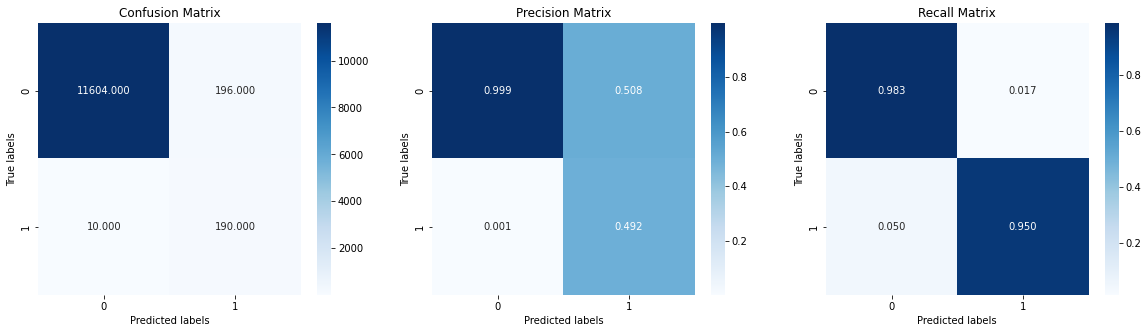

In [164]:
#model_list,clf_meta = stacking_classifier(X_D1,Y_D1,X_D2,Y_D2,10)
y_pred_final = stacking_classifier_predict(model_list,clf_meta,X_cv)

Fbeta_final = F_Beta_score(Y_cv,y_pred_final)
cost_final = Cost(Y_cv, y_pred_final)

print('F-Beta score : ',Fbeta_final)
print('Total_cost   : ',cost_final)
matrix_heatmaps(Y_cv, y_pred_final)

In [177]:
pickle.dump(clf_meta, open('models_2//stacking.pkl', 'wb'))

pickle.dump(model_list[0], open('models_2//base_rf.pkl', 'wb'))
pickle.dump(model_list[1], open('models_2//base_xgb.pkl', 'wb'))
pickle.dump(model_list[2], open('models_2//base_svm.pkl', 'wb'))
pickle.dump(model_list[3], open('models_2//base_lr.pkl', 'wb'))
pickle.dump(model_list[4], open('models_2//base_knn.pkl', 'wb'))

pickle.dump(model_list[5], open('models_2//base_rf_2.pkl', 'wb'))
pickle.dump(model_list[6], open('models_2//base_xgb_2.pkl', 'wb'))
pickle.dump(model_list[7], open('models_2//base_svm_2.pkl', 'wb'))
pickle.dump(model_list[8], open('models_2//base_lr_2.pkl', 'wb'))
pickle.dump(model_list[9], open('models_2//base_knn_2.pkl', 'wb'))

In [ ]:
# load the model from disk
#clf_meta = pickle.load(open('models_2//stacking.pkl', 'rb'))

## Observations

- For the custom classifier model, we have used 10 base models where 5 different classifier models were used twice (Random Forest, XGBoost, Linear SVM and Logistic regression and KNN ). The predictions from these 10 base models was obtained. 


- Based on this, a new dataset was created and using this dataset a Meta classifier (logistic regression) model was trained.
 Then the C.V data was used for the evaluation process.


- Initially the C.V data was passed through all the 10 base models and the predictions were obtained. From these 10 predictions, a dataset was created and this was passed through the Meta classifier model to get the final predictions. 


- Then using the final prediction and the targets for the C.V data, the model performance was calcualted.


- From the evaluation of the model, we have obtained an F_Beta score of 0.807.


- The total_cost obtained using the custom stacking classifier model is 7310, which is lower than the current lowest cost obtained by the Random Forst classifier model. Hence we could say that the model performance has been increased by using the custom classifier model